# Homework 2 – Differential Privacy Protection

In this notebook we apply **Differential Privacy (DP)** techniques to the same *Crypto* wallet dataset used in Homework 1 (microdata protection).
We will move from classical anonymisation to both **local** and **central** differential privacy mechanisms, and study the privacy–utility trade-off.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (7.5, 4.5)
sns.set_context("talk")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Dataset loading

We reuse the *Crypto.csv* file from Homework 1.  
If you are running this notebook on Google Colab, make sure your Google Drive is mounted and that the path below is correct.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/MICAC/PPIA/Crypto.csv'

cols = [
    "address",
    "network",
    "country",
    "client_type",
    "last_active",
    "tx_count",
    "balance_usd",
    "mixer_usage",
    "sanctions_score",
    "high_risk"
]

crypto_wallet_df = pd.read_csv(PATH)[cols]
print("Shape:", crypto_wallet_df.shape)
crypto_wallet_df.head()

Shape: (10000, 10)


,address,network,country,client_type,last_active,tx_count,balance_usd,mixer_usage,sanctions_score,high_risk
0,19MCTdu6DPM4PpEiCiHd4zkw1rj8aRuezg,bitcoin,Germany,api,03/11/2023,1098,9429.42,never,13.0,False
1,tz1RjZnRPTVUmdE9rubXdBesHUcd9w9wRa5T,tezos,Portugal,desktop,12/05/2024,567,5214.24,never,0.0,False
2,0x6cdc950a633e6a3017e912f37c0e42bc30e5a57b,ethereum,France,desktop,22/02/2024,883,5383.56,never,1.0,False
3,0xc979190276c43e7251ac754334daf0b1c851e8db,ethereum,Poland,mobile,25/12/2024,68,307160.56,never,2.0,False
4,1GCJgPxPKCdXYHRRQxQCeSuaZRwBKLC9QL,bitcoin,Sweden,api,05/01/2025,1020,5717.60,never,0.0,False


## 2. Reminder: Differential Privacy

A randomized mechanism $( \mathcal{M} )$ gives **$(\varepsilon, \delta)$-Differential Privacy** if for all neighbouring datasets $( D )$ and $( D' )$  
(that differ in the data of a single individual), and for all measurable sets of outputs $( S )$:

$$
\Pr[\,\mathcal{M}(D) \in S\,] \le e^{\varepsilon} \Pr[\,\mathcal{M}(D') \in S\,] + \delta.
$$

In this homework we mainly focus on the **pure** DP case with $( \delta = 0 )$.  
Intuitively:
- **small $(\varepsilon)$**  → strong privacy, heavy noise, lower utility;  
- **large $(\varepsilon)$** → weaker privacy, less noise, higher utility.

## 3. Local Differential Privacy: Coin Toss Mechanism (Randomised Response)

In **Local Differential Privacy (LDP)**, each individual perturbs their value *before* sending it to the data collector.  
We consider a binary attribute $x \in \{0,1\}$, such as the indicator `high_risk`.

The **Coin Toss Mechanism** (randomised response) works as follows for each individual:

1. With probability

$$
p = \frac{e^{\varepsilon}}{e^{\varepsilon} + 1}
$$

the mechanism returns the **true** value $x$.

2. With probability $1 - p$, the mechanism ignores the true value and returns a **fair coin flip** in $\{0,1\}$.

This mechanism satisfies **$\varepsilon$-Local DP**.

In our dataset we can naturally apply it to the binary column `high_risk` (0/1).


In [ ]:
def coin_toss_mechanism_bool(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)

    if np.random.rand() < p:
        # tell the truth
        return bool(x)
    else:
        # return a fair coin flip: True or False
        return bool(np.random.rand() < 0.5)


epsilon_ldp = 0.5
crypto_wallet_df['high_risk_coin_toss'] = (
    crypto_wallet_df['high_risk'].apply(lambda v: coin_toss_mechanism_bool(v, epsilon_ldp))
)


crypto_wallet_df[['high_risk', 'high_risk_coin_toss']].head()


,high_risk,high_risk_coin_toss
0,False,False
1,False,False
2,False,True
3,False,False
4,False,False


To recover the original proportion of `True` values after applying the randomized response mechanism, we use the fact that the perturbation has a known expected value. In $\varepsilon$-randomized response, each user tells the truth with probability $p$ and answers with a fair coin flip with probability $(1 - p)$. This implies that the expected value of the perturbed responses is

$$
E[Y] = p \cdot q + (1 - p) \cdot 0.5,
$$

where $q$ is the true (unknown) proportion of 1’s in the dataset. By solving this expression for $q$, we obtain an unbiased estimator of the original rate. The function below implements this correction.


In [ ]:
def estimate_true_rate(observed_rate, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1.0)
    return (observed_rate - 0.5 * (1 - p)) / p

true_rate = crypto_wallet_df['high_risk'].mean()
observed_rate = crypto_wallet_df['high_risk_coin_toss'].mean()
estimated_rate = estimate_true_rate(observed_rate, epsilon_ldp)

print(f"True high_risk rate:       {true_rate:.4f}")
print(f"Observed (LDP) rate:      {observed_rate:.4f}")
print(f"Estimated true rate (DP): {estimated_rate:.4f}")

True high_risk rate:       0.1024
Observed (LDP) rate:      0.2529
Estimated true rate (DP): 0.1030


**Comment.**

- The *observed* LDP rate is biased because of the randomised response.
- Using the analytical inverse of the mechanism we can recover an **unbiased estimate** of the true rate.
- However, the estimate may still fluctuate due to randomness (variance), especially for small $(
\varepsilon )$ or small sample size.

## 4. Central Differential Privacy: Laplace Mechanism

We now switch to the **central** DP model, where we assume a trusted curator
holds the raw data and releases only noisy query answers.

For a numeric query $f(D)$, the **global sensitivity** is defined as:

$$
\Delta f = \max_{D, D'} \lVert f(D) - f(D') \rVert_1,
$$

where $D$ and $D'$ are neighbouring datasets that differ in exactly one individual.

The **Laplace mechanism** releases a noisy version of the query:

$$
\mathcal{M}(D) = f(D) + \text{Laplace}\left(0, \frac{\Delta f}{\varepsilon}\right).
$$

In [ ]:
def laplace_mechanism(true_value, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale)
    return true_value + noise

### 4.1 DP count of high-risk addresses

We first consider the query:

> "How many addresses are high-risk?"

This is a **count query** with sensitivity $( \Delta f = 1 )$ (adding or removing one individual can change the count by at most 1).

In [ ]:
true_count = int(crypto_wallet_df['high_risk'].sum())
print("True count of high-risk addresses:", true_count)

epsilons = [0.1, 0.5, 1.0, 2.0]
n_rep = 200

results = {}
for eps in epsilons:
    noisy_counts = [
        laplace_mechanism(true_count, eps, sensitivity=1.0)
        for _ in range(n_rep)
    ]
    results[eps] = noisy_counts
    print(f"epsilon = {eps:.1f} | mean noisy count = {np.mean(noisy_counts):.2f} | std = {np.std(noisy_counts):.2f}")

True count of high-risk addresses: 1024
epsilon = 0.1 | mean noisy count = 1024.58 | std = 14.52
epsilon = 0.5 | mean noisy count = 1023.93 | std = 2.72
epsilon = 1.0 | mean noisy count = 1023.90 | std = 1.50
epsilon = 2.0 | mean noisy count = 1024.05 | std = 0.71


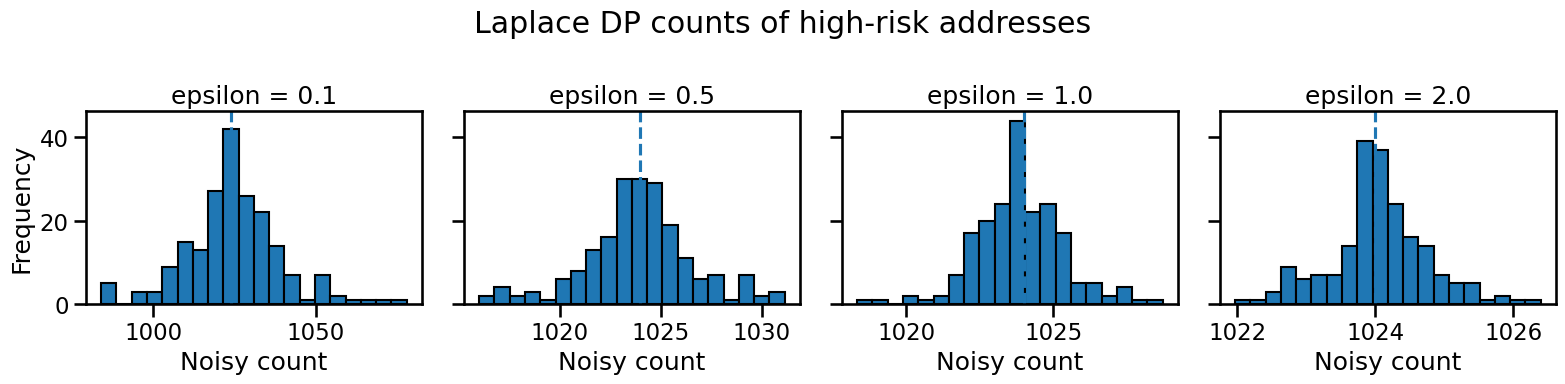

In [ ]:
fig, axes = plt.subplots(1, len(epsilons), figsize=(16, 4), sharey=True)

for ax, eps in zip(axes, epsilons):
    ax.hist(results[eps], bins=20, edgecolor='black')
    ax.axvline(true_count, linestyle='--')
    ax.set_title(f'epsilon = {eps}')
    ax.set_xlabel('Noisy count')

axes[0].set_ylabel('Frequency')
fig.suptitle('Laplace DP counts of high-risk addresses')
plt.tight_layout()
plt.show()

### 4.2 DP mean of `balance_usd` with clipping

Now we consider the mean of a **numeric attribute** (`balance_usd`).  
To control the sensitivity we:

1. **Clip** all values to a fixed range $([L, U])$.
2. Compute the (clipped) mean.
3. Add Laplace noise with scale $( \Delta f / \varepsilon )$, where
$$
\Delta f = \frac{U - L}{n}
$$
for a dataset of size $(n)$.

In [ ]:
def dp_mean(values, epsilon, lower, upper):
    values = np.asarray(values, dtype=float)
    clipped = np.clip(values, lower, upper)
    n = clipped.size
    true_mean = clipped.mean()
    sensitivity = (upper - lower) / n
    noisy_mean = laplace_mechanism(true_mean, epsilon, sensitivity)
    return noisy_mean, true_mean


low = crypto_wallet_df['balance_usd'].quantile(0.01)
high = crypto_wallet_df['balance_usd'].quantile(0.99)
print(f"Clipping bounds: [{low:.2f}, {high:.2f}]")

Clipping bounds: [96.36, 260448.96]


In [ ]:
epsilons_mean = [0.1, 0.5, 1.0, 2.0]
n_rep = 200

mean_results = []
for eps in epsilons_mean:
    noisy_means = []
    for _ in range(n_rep):
        noisy, true_mean = dp_mean(crypto_wallet_df['balance_usd'], eps, low, high)
        noisy_means.append(noisy)
    mean_results.append({
        'epsilon': eps,
        'noisy_means': noisy_means,
        'true_mean': true_mean
    })
    print(f"epsilon = {eps:.1f} | true mean (clipped) = {true_mean:.2f} | noisy mean avg = {np.mean(noisy_means):.2f}")

epsilon = 0.1 | true mean (clipped) = 6266.89 | noisy mean avg = 6306.55
epsilon = 0.5 | true mean (clipped) = 6266.89 | noisy mean avg = 6265.46
epsilon = 1.0 | true mean (clipped) = 6266.89 | noisy mean avg = 6265.87
epsilon = 2.0 | true mean (clipped) = 6266.89 | noisy mean avg = 6266.71


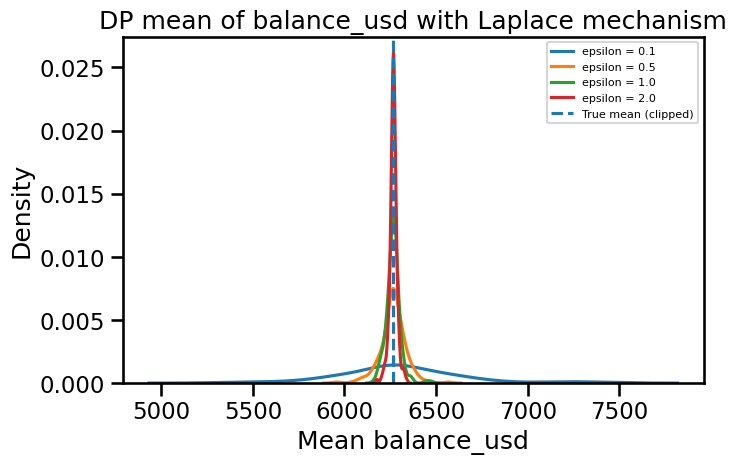

In [ ]:
fig, ax = plt.subplots()

for res in mean_results:
    eps = res['epsilon']
    noisy_means = res['noisy_means']
    sns.kdeplot(noisy_means, label=f'epsilon = {eps}', ax=ax)

ax.axvline(mean_results[0]['true_mean'], linestyle='--', label='True mean (clipped)')
ax.set_xlabel('Mean balance_usd')
ax.set_title('DP mean of balance_usd with Laplace mechanism')
ax.legend(prop={'size': 8})
plt.show()

**Comment.**

- Lower epsilon produces a **wider** (more noisy) distribution of DP means.
- Larger epsilon yields DP means concentrated around the true clipped mean.
- Clipping controls sensitivity but may introduce bias if many values are outside \([L, U]\).

## 5. DP histogram of high-risk addresses per country

We now study the distribution of high-risk addresses across countries.  
We will release a **DP histogram** of counts by adding Laplace noise to each bin.

For a simple histogram of counts, each bin has sensitivity 1 with respect to any individual (an address contributes to at most one bin).

country
Poland            139
France            138
Portugal          122
Sweden             99
Ukraine            82
Czech Republic     73
Greece             46
Finland            35
Serbia             25
Norway             23
dtype: int64


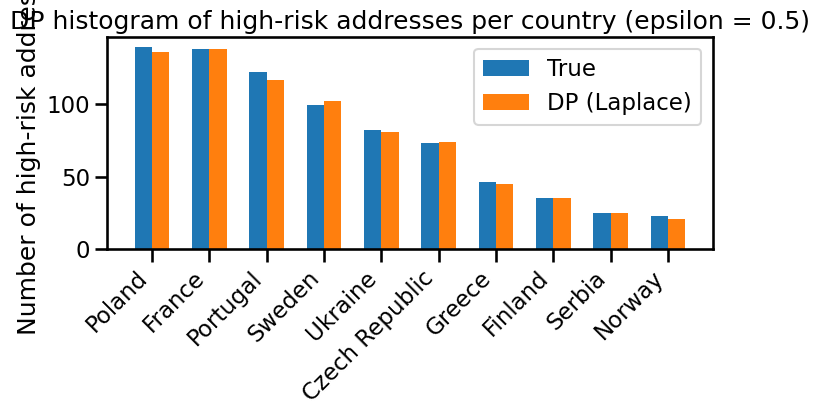

In [ ]:
def dp_histogram_counts(counts, epsilon, sensitivity=1.0):
    counts = np.asarray(counts, dtype=float)
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale, size=counts.shape)
    return counts + noise


country_counts = (
    crypto_wallet_df[crypto_wallet_df['high_risk'] == 1]
    .groupby('country')
    .size()
    .sort_values(ascending=False)
)

top_countries = country_counts.head(10)
print(top_countries)

epsilon_hist = 0.5
noisy_top_counts = dp_histogram_counts(top_countries.values, epsilon_hist)

plt.bar(np.arange(len(top_countries)) - 0.15, top_countries.values, width=0.3, label='True')
plt.bar(np.arange(len(top_countries)) + 0.15, noisy_top_counts, width=0.3, label='DP (Laplace)')
plt.xticks(np.arange(len(top_countries)), top_countries.index, rotation=45, ha='right')
plt.ylabel('Number of high-risk addresses')
plt.title(f'DP histogram of high-risk addresses per country (epsilon = {epsilon_hist})')
plt.legend()
plt.tight_layout()
plt.show()

## 6. Above Threshold: detecting problematic countries in a DP way

The **Above Threshold** mechanism is a classic DP tool to select queries
whose answer is above a given threshold, while preserving privacy.

Here we consider queries of the form:

$$
q_c(D) = \text{mean sanctions score for country } c.
$$

We then ask:

> "Find the first country whose mean sanctions score is above threshold $(T)$"

in a differentially private way.

In [ ]:
def above_threshold(queries, T, epsilon):
    noisy_T = laplace_mechanism(T, epsilon / 2.0, sensitivity=1.0)
    remaining_eps = epsilon / 2.0

    for name, value in queries:
        noisy_value = laplace_mechanism(value, remaining_eps, sensitivity=1.0)
        if noisy_value >= noisy_T:
            return name, value, noisy_value, noisy_T

    return None, None, None, noisy_T


country_sanctions = (
    crypto_wallet_df
    .groupby('country')['sanctions_score']
    .mean()
    .sort_values(ascending=False)
)

topK = 10
queries = list(country_sanctions.head(topK).items())
T = country_sanctions.quantile(0.75)  # threshold: 75th percentile of mean sanctions
epsilon_AT = 1.0

winner, true_val, noisy_val, noisy_T = above_threshold(queries, T, epsilon_AT)
print("Threshold T (true):", T)
print("Noisy threshold:", noisy_T)
print("Selected country (DP):", winner)
print("True mean sanctions of winner:", true_val)
print("Noisy value used for selection:", noisy_val)

Threshold T (true): 7.2482019008476755
Noisy threshold: 12.847521805200238
Selected country (DP): Slovakia
True mean sanctions of winner: 20.571428571428573
Noisy value used for selection: 22.169624964584965


### Microsoft 1-bit Local Differential Privacy

To privately estimate the mean of a numerical attribute, we apply Microsoft's 1-bit LDP mechanism.  
Each user first normalizes their value to the range \([0,1]\) and then encodes it into **a single randomized bit**, instead of sending the true value.  
The bit is generated with a probability that depends on both the normalized value and the privacy parameter $(\varepsilon)$.  
Although the data collector only receives noisy bits, an unbiased estimator allows reconstructing the original mean of the attribute.

In [ ]:
# Attribute to privatize (same as before)
X = crypto_wallet_df['balance_usd'].values.astype(float)
m = X.max()
X_norm = X / m   # normalize to [0,1]

def one_bit_ldp(x, epsilon):
    e = np.exp(epsilon)
    p = (1 / (e + 1)) + x * ((e - 1) / (e + 1))
    return np.random.rand() < p  # True/False

def estimate_mean_from_bits(bits, epsilon, m):
    e = np.exp(epsilon)
    Ybar = bits.mean()
    mu_hat = m * ((Ybar * (e + 1) - 1) / (e - 1))
    return mu_hat

eps_values = [0.3, 0.5, 1.0, 2.0, 3.5, 5.0]

results = []
for eps in eps_values:
    bits = np.array([one_bit_ldp(v, eps) for v in X_norm], dtype=int)
    mu_est = estimate_mean_from_bits(bits, eps, m)
    results.append(mu_est)

mu_true = X.mean()

epsilon = 0.3: estimated mean = 11911.2863 (true = 7471.8288)
epsilon = 0.5: estimated mean = 10545.5519 (true = 7471.8288)
epsilon = 1.0: estimated mean = 9596.4308 (true = 7471.8288)
epsilon = 2.0: estimated mean = 9331.9661 (true = 7471.8288)
epsilon = 3.5: estimated mean = 7544.8219 (true = 7471.8288)
epsilon = 5.0: estimated mean = 7310.1861 (true = 7471.8288)


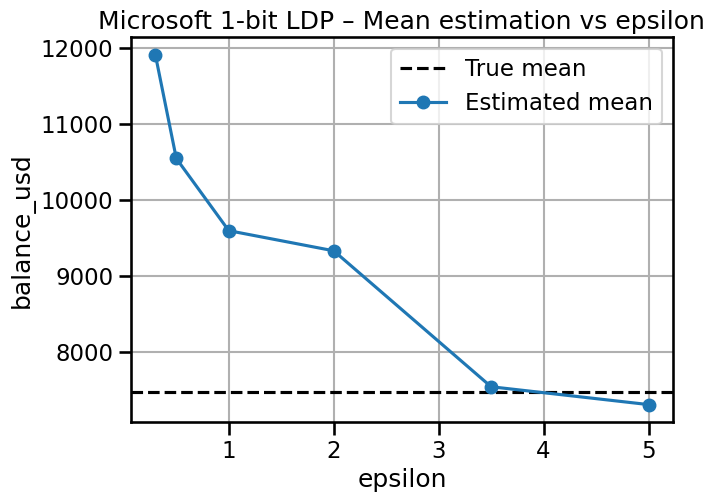

In [ ]:
for eps, est in zip(eps_values, results):
    print(f"epsilon = {eps}: estimated mean = {est:.4f} (true = {mu_true:.4f})")

plt.figure(figsize=(7,5))
plt.axhline(mu_true, color='black', linestyle='--', label="True mean")
plt.plot(eps_values, results, marker='o', label="Estimated mean")
plt.xlabel("epsilon")
plt.ylabel("balance_usd")
plt.title("Microsoft 1-bit LDP – Mean estimation vs epsilon")
plt.legend()
plt.grid(True)
plt.show()